In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from sklearn.neighbors import KNeighborsRegressor

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

%matplotlib inline
plt.style.use('ggplot')

In [11]:
file_path = "batdongsan_data_scaled.csv"
df = pd.read_csv(file_path)
df.head()

,title,link,address,legal,furniture,post_date,loai_bds,district,price_ty,area_m2,bedrooms_num,toilets_num
0,Ban công Đông Nam - Không Mất Phí Môi Giới chí...,https://batdongsan.com.vn/ban-can-ho-chung-cu-...,"Dự án Vinhomes Ocean Park Gia Lâm, Xã Dương Xá...",Sổ đỏ/ Sổ hồng,Cơ bản,18/10/2025,Căn hộ chung cư,Gia Lâm,0.213389,0.399015,0.032258,0.03125
1,"Giá chỉ từ 2 tỷ, đất đô thị Hòa Lạc, gần QL21 ...",https://batdongsan.com.vn/ban-dat-xa-phu-cat-1...,"Xã Phú Cát, Quốc Oai, Hà Nội",Sổ đỏ/ Sổ hồng,Missing,18/10/2025,Đất nền/Thổ cư,Quốc Oai,0.038805,0.487685,0.064516,0.06250
2,Bán biệt thự mặt công viên 65hecta tại KĐT Cip...,https://batdongsan.com.vn/ban-nha-biet-thu-lie...,"Dự án Kita Capital Ciputra, Phường Phú Thượng,...",Sổ đỏ/ Sổ hồng,Không nội thất,13/10/2025,Biệt thự/Liền kề,Tây Hồ,0.970576,0.684729,0.064516,0.06250
3,Missing,https://batdongsan.com.vn/ban-dat-duong-hoi-ph...,"Đường Hội Phụ, Xã Đông Hội, Đông Anh, Hà Nội",Sổ đỏ/ Sổ hồng,Missing,18/10/2025,Đất nền/Thổ cư,Đông Anh,0.109423,0.399015,0.064516,0.06250
4,Missing,https://batdongsan.com.vn/ban-nha-rieng-duong-...,"Đường Quan Hoa, Phường Quan Hoa, Cầu Giấy, Hà Nội",Sổ đỏ vuông đẹp.,Missing,18/10/2025,Nhà riêng/Khác,Cầu Giấy,0.259487,0.226601,0.064516,0.06250


In [12]:
target_column = 'price_ty'

numeric_features = ['area_m2', 'bedrooms_num', 'toilets_num']

categorical_features = ['loai_bds', 'district', 'legal']

#Tạo X (toàn bộ đặc trưng) và y (mục tiêu)
X = df[numeric_features + categorical_features]
y = df[target_column]

In [13]:
#Định nghĩa bộ xử lý cho cột số ('passthrough' = giữ nguyên)
numeric_transformer = 'passthrough'

#Định nghĩa bộ xử lý cho cột chữ
categorical_transformer = OneHotEncoder(handle_unknown='ignore', sparse_output=False)

#Kết hợp 2 bộ xử lý bằng ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ],
    remainder='drop' # Bỏ qua các cột không được liệt kê (như title, link, address)
)

In [14]:
#Tạo Pipeline Mô hình KNN

knn_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', KNeighborsRegressor())
])

In [15]:
#Chia dữ liệu
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Kích thước tập Train: {X_train.shape[0]} mẫu")
print(f"Kích thước tập Test: {X_test.shape[0]} mẫu")

#Định nghĩa lưới tham số K
k_range = list(range(1, 31))
param_grid = {'regressor__n_neighbors': k_range}

#Khởi tạo GridSearchCV
#n_jobs=-1: Sử dụng tất cả CPU để chạy nhanh hơn
grid_search = GridSearchCV(knn_pipeline, 
                           param_grid, 
                           cv=10, 
                           scoring='neg_mean_squared_error', 
                           n_jobs=-1)

#Huấn luyện GridSearch
grid_search.fit(X_train, y_train)

#In ra kết quả K tốt nhất
best_k = grid_search.best_params_['regressor__n_neighbors']
print(f"\nGiá trị K tốt nhất là: {best_k}")

Kích thước tập Train: 2055 mẫu
Kích thước tập Test: 514 mẫu

Giá trị K tốt nhất là: 7


In [16]:
#Lấy ra mô hình tốt nhất
best_knn_model = grid_search.best_estimator_

#Dự đoán trên tập Test
y_pred = best_knn_model.predict(X_test)

#Tính toán các chỉ số
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print(f"  R-squared (R2): {r2:.4f}")
print(f"  Mean Absolute Error (MAE): {mae:.4f}")
print(f"  Root Mean Squared Error (RMSE): {rmse:.4f}")

  R-squared (R2): 0.4860
  Mean Absolute Error (MAE): 0.0901
  Root Mean Squared Error (RMSE): 0.1392


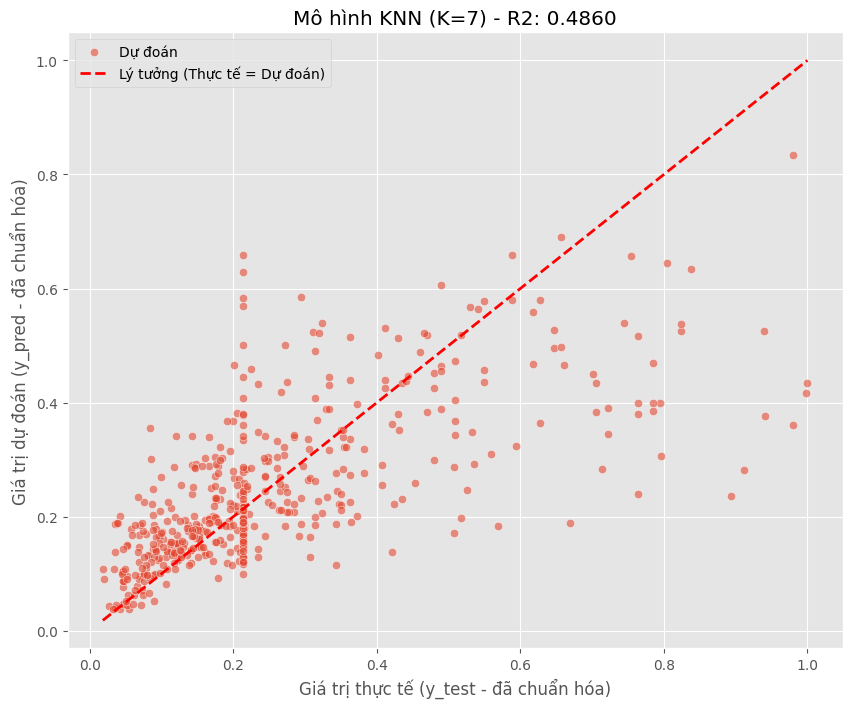

In [17]:
#Trực quan hóa kết quả

plt.figure(figsize=(10, 8))

# Vẽ biểu đồ scatter 
sns.scatterplot(x=y_test, y=y_pred, alpha=0.6, label='Dự đoán')

# Vẽ đường chéo (y=x)
line_max = max(y_test.max(), y_pred.max())
line_min = min(y_test.min(), y_pred.min())
plt.plot([line_min, line_max], [line_min, line_max], 'r--', lw=2, label='Lý tưởng (Thực tế = Dự đoán)')

plt.xlabel("Giá trị thực tế (y_test - đã chuẩn hóa)")
plt.ylabel("Giá trị dự đoán (y_pred - đã chuẩn hóa)")
plt.title(f"Mô hình KNN (K={best_k}) - R2: {r2:.4f}")
plt.legend()
plt.grid(True)
plt.show()